In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns 

# df = pd.read_csv('../data/time_series_19-covid-Confirmed.csv')

Using TensorFlow backend.


In [2]:
sars = pd.read_csv('../data/sars_chn_agg.csv')
sars.Date = pd.to_datetime(sars.Date)
s = sars.groupby('Date').agg('sum')
s.index = pd.to_datetime(s.index)
s1 = s[['Cumulative_Number_Of_Case(s)']].rename(columns={'Cumulative_Number_Of_Case(s)':'Confirmed'})


In [57]:
# define LSTM model in function to make predictions
def LSTM_train(df, timesteps, n_features):
    # df is the pandas dataframe will be used as datasource for ML prediction
    # df index should be datetime format timeseries timestamps | TimeSeries is univariate 
    # timesteps is the desired interval of time for machine to learn and to make prediction | eg. timesteps = 12 | 
    # n_features is the amount of supervised value machine predicts | eg. n_features = 1 | currently function allows 1
    # add. argument col_name is the column in df which contains the value to predict
    # col_name should be a string | eg. col_name = 'Confirmed'
    # currently allows 1 col* if predicting multiple values, cal_name should be a list of strings; pass columns using indexing | eg. df[col_name[0]]

    #splitting train and test dataset 
    train, test = df[:-12], df[-12:]
    #scale data to a range between 0 and 1 using MinMax 
    #for machine to better learn sequence
    scaler = MinMaxScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    # define TS generator for X, y values 
    # data: features | targets: values
    # length: length of output | batch_size: number of timeseries samples each batch
    generator = TimeseriesGenerator(data=train_scaled, targets=train_scaled, length=timesteps, batch_size=6)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(timesteps, n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=['mae','acc'])
    model.fit_generator(generator,epochs=2)
    # converting univariate TS data to supervised
    pred_list = []
    batch = train_scaled[-timesteps:].reshape((1, timesteps, n_features))

    for i in range(timesteps):   
        pred_list.append(model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
        #appending prediction to the list while excluding first data used for prediction | keeping window size constant at timesteps amount

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                            index=df[-timesteps:].index, columns=['Prediction'])

    df_test = pd.concat([df,df_predict], axis=1)

    sns.set(style='whitegrid')
    palette=sns.color_palette('hot_r',2)
    ax = sns.lineplot(data=df_test,style='Prediction',size=(20,5),palette=palette,hue='Prediction')
    plt.title('LSTM Prediction vs. Actual Data')
    plt.legend(loc='best', fontsize='medium')
    plt.xticks(fontsize=10,rotation=45)
    plt.yticks(fontsize=10)
    pred_actual_rmse = rmse(df_test.iloc[-timesteps:, [0]], df_test.iloc[-timesteps:, [1]])
    print('RMSE of prediction: %f.' % pred_actual_rmse)
    return model, df_test, pred_actual_rmse[0]

poch 1/180
12/12 [==============================] - 1s 73ms/step - loss: 0.3962 - mae: 0.5817 - acc: 0.0000e+00
Epoch 2/180
12/12 [==============================] - 0s 27ms/step - loss: 0.0993 - mae: 0.2617 - acc: 0.0139
Epoch 3/180
12/12 [==============================] - 0s 27ms/step - loss: 0.0328 - mae: 0.1500 - acc: 0.0139
Epoch 4/180
12/12 [==============================] - 0s 31ms/step - loss: 0.0257 - mae: 0.1306 - acc: 0.0139
Epoch 5/180
12/12 [==============================] - 0s 29ms/step - loss: 0.0084 - mae: 0.0793 - acc: 0.0139
Epoch 6/180
12/12 [==============================] - 0s 33ms/step - loss: 0.0051 - mae: 0.0612 - acc: 0.0139
Epoch 7/180
12/12 [==============================] - 0s 31ms/step - loss: 0.0042 - mae: 0.0556 - acc: 0.0139
Epoch 8/180
12/12 [==============================] - 0s 32ms/step - loss: 0.0058 - mae: 0.0589 - acc: 0.0139
Epoch 9/180
12/12 [==============================] - 0s 42ms/step - loss: 0.0047 - mae: 0.0586 - acc: 0.0139
Epoch 10/180
12/

(<keras.engine.sequential.Sequential at 0x17a32d4f888>,
             Confirmed   Prediction
 Date                              
 2003-03-17        167          NaN
 2003-03-18        219          NaN
 2003-03-19        264          NaN
 2003-03-20        306          NaN
 2003-03-21        350          NaN
 ...               ...          ...
 2003-07-07       8434  8459.609996
 2003-07-08       8431  8459.803268
 2003-07-09       8431  8460.003954
 2003-07-10       8432  8460.226390
 2003-07-11       8432  8460.453769
 
 [96 rows x 2 columns],
 23.044137824633086)

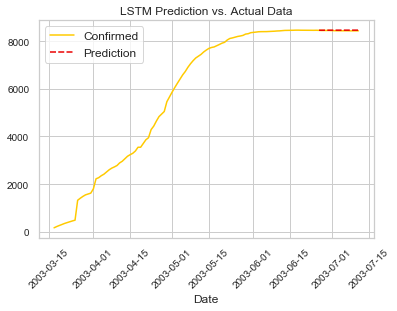

In [50]:
LSTM_train(s1,12,1)

In [64]:
# a = LSTM_step1(s1,12,1,'Confirmed')
# a[3]

========================] - 1s 69ms/step - loss: 0.3424 - mae: 0.5196 - acc: 0.0000e+00
Epoch 2/180
12/12 [==============================] - 0s 31ms/step - loss: 0.0466 - mae: 0.1650 - acc: 0.0139
Epoch 3/180
12/12 [==============================] - 0s 33ms/step - loss: 0.0725 - mae: 0.2382 - acc: 0.0139
Epoch 4/180
12/12 [==============================] - 0s 30ms/step - loss: 0.0230 - mae: 0.1311 - acc: 0.0139
Epoch 5/180
12/12 [==============================] - 1s 43ms/step - loss: 0.0105 - mae: 0.0824 - acc: 0.0139
Epoch 6/180
12/12 [==============================] - 0s 28ms/step - loss: 0.0082 - mae: 0.0713 - acc: 0.0139
Epoch 7/180
12/12 [==============================] - 0s 33ms/step - loss: 0.0057 - mae: 0.0632 - acc: 0.0139
Epoch 8/180
12/12 [==============================] - 0s 33ms/step - loss: 0.0066 - mae: 0.0661 - acc: 0.0139
Epoch 9/180
12/12 [==============================] - 0s 29ms/step - loss: 0.0055 - mae: 0.0646 - acc: 0.0139
Epoch 10/180
12/12 [====================

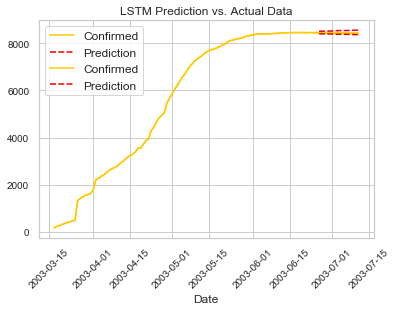

In [52]:
results = {}
for i in range(2):
    results[i] = LSTM_train(s1,12,1)

Epoch 1/2
12/12 [==============================] - 1s 45ms/step - loss: 0.5180 - mae: 0.6478 - acc: 0.0000e+00
Epoch 2/2
12/12 [==============================] - 0s 14ms/step - loss: 0.1161 - mae: 0.2961 - acc: 0.0000e+00
RMSE of prediction: 5394.426651.
Epoch 1/2
12/12 [==============================] - 1s 53ms/step - loss: 0.4099 - mae: 0.5681 - acc: 0.0000e+00
Epoch 2/2
12/12 [==============================] - 0s 11ms/step - loss: 0.0325 - mae: 0.1255 - acc: 0.0139
RMSE of prediction: 683.141612.


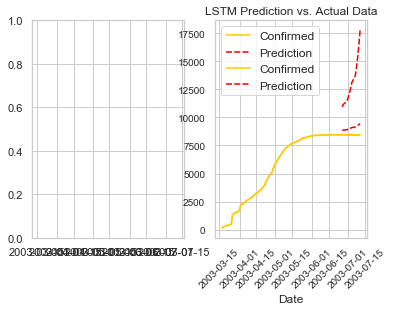

In [72]:
def avg_performance(run_time,val_ind):
    f, axes = plt.subplots(1, run_time, sharex=True)
    global func_result
    k=0
    func_result = []
    while run_time > 0:
        ax = axes[k]
        func_result.append(LSTM_train(s1,12,1))
        df = func_result[1]
        
        run_time -= 1
    avg = np.mean([[func_result[i][val_ind]]for i in range(len(func_result))])
    return avg

testa = avg_performance(2,2)

In [68]:
testa

2028.660384836653

In [3]:
# define function to project future vales
def LSTM_project(df,timesteps,n_features,future_days):
    train = df
    scaler = MinMaxScaler()
    train_scaled = scaler.fit(train).transform(train)
    generator = TimeseriesGenerator(data=train_scaled, targets=train_scaled, length=timesteps, batch_size=6)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(timesteps, n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=['mae','acc'])
    model.fit_generator(generator,epochs=180)

    pred_list = []
    batch = train_scaled[-timesteps:].reshape((1, timesteps, n_features))

    for i in range(timesteps):   
        pred_list.append(model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)


    from pandas.tseries.offsets import DateOffset
    add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,future_days) ]
    future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                            index=future_dates[-timesteps:].index, columns=['Prediction'])

    df_proj = pd.concat([df,df_predict], axis=1)

    sns.set(style='whitegrid')
    palette=sns.color_palette('hot_r',2)
    ax = sns.lineplot(data=df_proj,style='Prediction',size=(20,5),palette=palette,hue='Prediction')
    plt.title('LSTM Projection vs. Actual Data')
    plt.legend(loc='best', fontsize='medium')
    plt.xticks(fontsize=10,rotation=45)
    plt.yticks(fontsize=10)
    return model, df_proj, ax


In [61]:
func_result

NameError: name 'func_result' is not defined

Epoch 1/180
14/14 [==============================] - 1s 56ms/step - loss: 0.3205 - mae: 0.4996 - acc: 0.0119
Epoch 2/180
14/14 [==============================] - 0s 17ms/step - loss: 0.0365 - mae: 0.1534 - acc: 0.0119
Epoch 3/180
14/14 [==============================] - 0s 18ms/step - loss: 0.0242 - mae: 0.1326 - acc: 0.0119
Epoch 4/180
14/14 [==============================] - 0s 19ms/step - loss: 0.0092 - mae: 0.0809 - acc: 0.0119
Epoch 5/180
14/14 [==============================] - 0s 17ms/step - loss: 0.0049 - mae: 0.0596 - acc: 0.0119
Epoch 6/180
14/14 [==============================] - 0s 18ms/step - loss: 0.0044 - mae: 0.0543 - acc: 0.0119
Epoch 7/180
14/14 [==============================] - 0s 17ms/step - loss: 0.0054 - mae: 0.0597 - acc: 0.0119
Epoch 8/180
14/14 [==============================] - 0s 16ms/step - loss: 0.0039 - mae: 0.0520 - acc: 0.0119
Epoch 9/180
14/14 [==============================] - 0s 18ms/step - loss: 0.0032 - mae: 0.0460 - acc: 0.0119
Epoch 10/180
14/14 

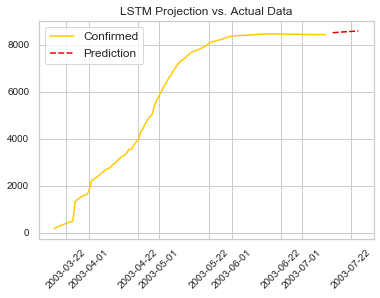

In [36]:
a = LSTM_project(s1,12,1,15)

In [38]:
# LSTM_step1(s1.diff().fillna(0),12,1,'Confirmed')
model = a[0]

In [34]:
cv = pd.read_csv('../data/time_series_19-covid-Confirmed.csv')
cov = cv.T[4:]
cov['Confirmed'] = list(cv[cv.columns[4:]].sum().values)
cov = cov[['Confirmed']].reset_index().rename(columns={'index':'Timeline'}).set_index('Timeline')
cov.index=pd.to_datetime(cov.index)

(array([-25000.,      0.,  25000.,  50000.,  75000., 100000., 125000.,
        150000., 175000., 200000.]),
 <a list of 10 Text yticklabel objects>)

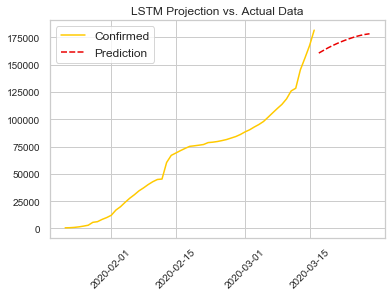

In [48]:
# plot cov19 data on sars fitted lstm model 
train = cov
scaler = MinMaxScaler()
train_scaled = scaler.fit(train).transform(train)
timesteps=12
n_features=1
future_days=13
pred_list = []
batch = train_scaled[-timesteps:].reshape((1, timesteps, n_features))

for i in range(timesteps):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)


from pandas.tseries.offsets import DateOffset
add_dates = [cov.index[-1] + DateOffset(days=x) for x in range(0,future_days) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=cov.columns)

df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                        index=future_dates[-timesteps:].index, columns=['Prediction'])

df_proj = pd.concat([cov,df_predict], axis=1)

sns.set(style='whitegrid')
palette=sns.color_palette('hot_r',2)
ax = sns.lineplot(data=df_proj,style='Prediction',size=(20,5),palette=palette,hue='Prediction')
plt.title('LSTM Projection vs. Actual Data')
plt.legend(loc='best', fontsize='medium')
plt.xticks(fontsize=10,rotation=45)
plt.yticks(fontsize=10)

In [ ]:
# define function to project sample B future vales using model fitted on sample A data
def LSTM_BonA(df1,df2,timesteps,n_features,future_days):
    trainA = df1
    scaler = MinMaxScaler()
    trainA_scaled = scaler.fit(trainA).transform(trainA)
    generator = TimeseriesGenerator(data=trainA_scaled, targets=trainA_scaled, length=timesteps, batch_size=6)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(timesteps, n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=['mae','acc'])
    model.fit_generator(generator,epochs=180)

    pred_list = []
    batch = train_scaled[-timesteps:].reshape((1, timesteps, n_features))

    for i in range(timesteps):   
        pred_list.append(model.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)


    from pandas.tseries.offsets import DateOffset
    add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,future_days) ]
    future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                            index=future_dates[-timesteps:].index, columns=['Prediction'])

    df_proj = pd.concat([df,df_predict], axis=1)

    sns.set(style='whitegrid')
    palette=sns.color_palette('hot_r',2)
    ax = sns.lineplot(data=df_proj,style='Prediction',size=(20,5),palette=palette,hue='Prediction')
    plt.title('LSTM Projection vs. Actual Data')
    plt.legend(loc='best', fontsize='medium')
    plt.xticks(fontsize=10,rotation=45)
    plt.yticks(fontsize=10)
    return model, df_proj, ax


In [2]:
cv = pd.read_csv('../data/time_series_19-covid-Confirmed.csv')
cov = cv.T[4:]
cov['Confirmed'] = list(cv[cv.columns[4:]].sum().values)
cov = cov[['Confirmed']].reset_index().rename(columns={'index':'Timeline'}).set_index('Timeline')
cov.index=pd.to_datetime(cov.index)


In [136]:
cv

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,117,129,149,149,197,238,428,566,673,790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,Aruba,Netherlands,12.5186,-70.0358,0,0,0,0,0,0,...,0,0,0,0,2,2,2,2,3,4
458,NaN,Zambia,-15.4167,28.2833,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
459,NaN,Djibouti,11.8251,42.5903,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
460,NaN,"Gambia, The",13.4432,-15.3101,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [117]:
chn = cv.groupby('Country/Region').agg('sum').T[['China']]#[:2].to_excel('../data/location.xlsx')
non_chn = cv.groupby('Country/Region').agg('sum').T[lst]
chn[2:].to_excel('../data/chn.xlsx')
non_chn[2:].to_excel('../data/non_chn.xlsx')
non_chn= non_chn[2:]
chn = chn[2:]
nonchn_val = list(non_chn.T.sum())
non_chn['Confirmed'] = nonchn_val
non_chn = non_chn[['Confirmed']].rename(columns={'Confirmed':'Outside_China_Confirmed'})
chn_val = list(chn.T.sum())
chn['Confirmed'] = chn_val
chn = chn[['Confirmed']].rename(columns={'Confirmed':'China_Confirmed'})

n_chn = pd.DataFrame(data=non_chn['Outside_China_Confirmed'],index=pd.to_datetime(non_chn.index)).reset_index().rename(columns={'index':'Date'}).set_index('Date')
i_chn = pd.DataFrame(data=chn['China_Confirmed'],index=pd.to_datetime(chn.index)).reset_index().rename(columns={'index':'Date'}).set_index('Date')
i_chn


,China_Confirmed
Date,
2020-01-22,548.0
2020-01-23,643.0
2020-01-24,920.0
2020-01-25,1406.0
2020-01-26,2075.0
2020-01-27,2877.0
2020-01-28,5509.0
2020-01-29,6087.0
2020-01-30,8141.0


In [126]:
pd.concat([i_chn,n_chn],axis=1).to_csv('../data/cov_chn_nonchn.csv')

In [142]:
def getRegional(region1,data):
    r1 = region1
    non_r1 = [i for i in data['Country/Region'] if i != r1]
    r1_v = data.groupby('Country/Region').agg('sum').T[[r1]]#[:2].to_excel('../data/location.xlsx')
    rest_v = data.groupby('Country/Region').agg('sum').T[non_r1]
    r1_v = r1_v[2:]
    rest_v = rest_v[2:]
    rest_val = list(rest_v.T.sum())
    rest_v['Confirmed'] = rest_val
    rest_v = rest_v[['Confirmed']].rename(columns={'Confirmed':''.join(['Outside_',r1,'_Confirmed'])})
    r1_val = list(r1_v.T.sum())
    r1_v['Confirmed'] = r1_val
    r1_v = r1_v[['Confirmed']].rename(columns={'Confirmed':''.join([r1,'_Confirmed'])})
    rest_df = pd.DataFrame(data=rest_v[''.join(['Outside_',r1,'_Confirmed'])],index=pd.to_datetime(rest_v.index)).reset_index().rename(columns={'index':'Date'}).set_index('Date')
    r1_df = pd.DataFrame(data=r1_v[''.join([r1,'_Confirmed'])],index=pd.to_datetime(r1_v.index)).reset_index().rename(columns={'index':'Date'}).set_index('Date')
    con = pd.concat([r1_df, rest_df],axis=1)
    return r1_df, rest_df, con

In [143]:
us_df, non_us, us_com = getRegional('US',cv)

In [45]:
a = cv.groupby('Country/Region').agg('sum').reset_index()
a.T[1:][3:]

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
1/26/20,0,0,0,0,0,0,0,4,0,0,...,0,5,0,0,0,0,0,0,2,0
1/27/20,0,0,0,0,0,0,0,5,0,0,...,0,5,0,0,0,0,0,0,2,0
1/28/20,0,0,0,0,0,0,0,5,0,0,...,0,5,0,0,0,0,0,0,2,0
1/29/20,0,0,0,0,0,0,0,6,0,0,...,0,5,0,4,0,0,0,0,2,0
1/30/20,0,0,0,0,0,0,0,9,0,0,...,0,5,0,4,0,0,0,0,2,0
1/31/20,0,0,0,0,0,0,0,9,0,0,...,0,7,0,4,2,0,0,0,2,0
2/1/20,0,0,0,0,0,0,0,12,0,0,...,0,8,0,4,2,0,0,0,6,0


In [55]:
pd.DataFrame(data = a.T[1:][3:].values, index=pd.to_datetime(a.T[1:].index[3:]),columns=a['Country/Region']).to_excel('../data/covTimelinedata1.xlsx')

In [56]:
pd.DataFrame(data = a.T[1:][1:3].values, index=a.T[1:].index[1:3],columns=a['Country/Region']).to_excel('../data/covTimelinedataLocation1.xlsx')

In [52]:
a['Country/Region']

0              Afghanistan
1                  Albania
2                  Algeria
3                  Andorra
4      Antigua and Barbuda
              ...         
147                Uruguay
148             Uzbekistan
149              Venezuela
150                Vietnam
151                 Zambia
Name: Country/Region, Length: 152, dtype: object

In [64]:
pd.DataFrame(data = a.T[1:][3:].values, index=pd.to_datetime(a.T[1:].index[3:]),columns=a['Country/Region']).T.to_excel('../data/covTimelinedata_a.xlsx')

In [65]:
us_com

NameError: name 'us_com' is not defined